<a href="https://colab.research.google.com/github/margot-bonilla/violent-behaviour-recognition/blob/master/notebooks/TFM_2024_Iteration_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violence Detection Iteration-1

In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
import os

# Crate necessary folders for the execution
info_path = '/content/Info'
if not os.path.exists(info_path):
    os.makedirs(info_path)

logs_path = '/content/logs'
if not os.path.exists(logs_path):
    os.makedirs(logs_path)

models_path = '/content/models/checkpoints'
if not os.path.exists(models_path):
    os.makedirs(models_path)

## Constant information to set the data and engineering resources

In [150]:
# Path information to load videos and annotations
import os

ROOT_PATH = r"/content/drive/MyDrive/UOC/TFM_2"
ANNOTATIONS_PATH = os.path.join(ROOT_PATH, "Annotations")
VIDEOS_PATH = os.path.join(ROOT_PATH, "Videos")
INFO_PATH = "Info"
MODELS_PATH = 'models'

LOGS_PATH = "logs"

DATASET_TRAIN_PATH = os.path.join(INFO_PATH, "violence_detection_train.hdf5")
DATASET_VAL_PATH = os.path.join(INFO_PATH, "violence_detection_val.hdf5")
DATASET_TEST_PATH = os.path.join(INFO_PATH, "violence_detection_test.hdf5")

# This command is to run all the cells on testing process
CREATE_DATASET = True
PLOT_FRAME_DISTRIBUTION = True

## Krakov
KRAKOV_VIDEOS_PATH = os.path.join(ROOT_PATH, "Videos")
INCLUDE_KRAKOV = True

## Hockey
HOCKEY_VIDEOS_PATH = os.path.join(ROOT_PATH, "Hockey", "data")
INCLUDE_HOCKEY = True

## Movies
MOVIES_VIDEOS_PATH = os.path.join(ROOT_PATH, "movies")
INCLUDE_MOVIES = True

## RWF 2000
RWF2000_VIDEOS_PATH = os.path.join(ROOT_PATH, "2 - data")
INCLUDE_RWF2000 = True

## RWF 2000
VIOLENT_VIDEOS_PATH = os.path.join(ROOT_PATH, "violentFlows", "ForTal")
INCLUDE_VIOLENT = True

IS_TEST_RUN = False
INSTALL_STUFF = False
LOAD_MODEL = False

EPOCHS = 30
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 5

MAX_NUM_FRAMES = 160

In [151]:
# global variables
# total_videos will contain the full path of each of the videos
total_normal_videos = list()
total_violent_videos = list()

In [152]:
# Dedup videos
all_video_names = set()

In [153]:
def include_videos(video_path, normal_prefix):
  for v in os.listdir(video_path):
    total_path = os.path.join(video_path, v)
    if v.startswith(normal_prefix) and v not in all_video_names:
      total_normal_videos.append(total_path)
      all_video_names.add(v)
    elif v not in all_video_names:
      total_violent_videos.append(total_path)
      all_video_names.add(v)

In [154]:
if INCLUDE_KRAKOV:
  include_videos(os.path.join(KRAKOV_VIDEOS_PATH), 'Normal')

In [155]:
if INCLUDE_HOCKEY:
  include_videos(os.path.join(HOCKEY_VIDEOS_PATH), 'no')

In [156]:
if INCLUDE_MOVIES:
  for f in os.listdir(MOVIES_VIDEOS_PATH):
    folder_path_normal = os.path.join(MOVIES_VIDEOS_PATH, f, "NonViolence")
    folder_path_violent = os.path.join(MOVIES_VIDEOS_PATH, f, "Violence")
    for normal in os.listdir(folder_path_normal):
      if normal not in all_video_names:
        total_normal_videos.append(os.path.join(folder_path_normal, normal))
        all_video_names.add(normal)
    for violent in os.listdir(folder_path_violent):
      if violent not in all_video_names:
        total_violent_videos.append(os.path.join(folder_path_violent, violent))
        all_video_names.add(violent)

In [157]:
if INCLUDE_RWF2000:
  for f in os.listdir(RWF2000_VIDEOS_PATH):
    folder_path_normal = os.path.join(RWF2000_VIDEOS_PATH, f, "NonFight")
    folder_path_violent = os.path.join(RWF2000_VIDEOS_PATH, f, "Fight")
    for normal in os.listdir(folder_path_normal):
      if normal not in all_video_names:
        total_normal_videos.append(os.path.join(folder_path_normal, normal))
        all_video_names.add(normal)
    for violent in os.listdir(folder_path_violent):
      if violent not in all_video_names:
        total_violent_videos.append(os.path.join(folder_path_violent, violent))
        all_video_names.add(violent)

In [158]:
if INCLUDE_VIOLENT:
  for v in os.listdir(VIOLENT_VIDEOS_PATH):
    if v not in all_video_names:
      total_violent_videos.append(os.path.join(VIOLENT_VIDEOS_PATH, v))
      all_video_names.add(v)

In [159]:
# Dedup videos
print("all video names: ", len(all_video_names))
print("all dedup video names: ", len(total_normal_videos) + len(total_violent_videos))

all video names:  6678
all dedup video names:  6678


In [160]:
print(f'Total of normal videos included: {len(total_normal_videos)}')
print(f'Total of violent videos included: {len(total_violent_videos)}')

Total of normal videos included: 4623
Total of violent videos included: 2055


# Plot distribution

In [161]:
import cv2
import os
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import progressbar

def create_frame_distribution(videos):
    number_of_frames = list()
    print(f"Total videos: {len(videos)}")
    bar = progressbar.ProgressBar(maxval=len(videos), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    processed = 0
    for video in videos:
        try:
            cap = cv2.VideoCapture(video)
            property_id = int(cv2.CAP_PROP_FRAME_COUNT)
            length = int(cv2.VideoCapture.get(cap, property_id))
            number_of_frames.append(length)
            cap.release()

            processed += 1
            bar.update(processed)

        except Exception as e:
            print(f"ERROR: {e.message}")
    bar.finish()

    return number_of_frames

def plot_frame_distribution(number_of_frames):
    frame_counts = np.array(number_of_frames)
    print("Number of unique frame counts:", len(frame_counts))
    print("Max frames in a video:", frame_counts.max())
    print("Min frames in a video:", frame_counts.min())
    print("Average frames per video:", frame_counts.mean())
    print("Median frames per video:", np.median(frame_counts))
    mode_value = st.mode(frame_counts).mode
    print("Mode frames per video:", mode_value)
    print("Videos over 2k frames:", np.sum(frame_counts > 2000))
    print("Videos over 5k frames:", np.sum(frame_counts > 5000))

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frame_counts, bins=100, color='skyblue', edgecolor='black')

    # Add vertical lines for mean, median, and mode
    plt.axvline(frame_counts.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(np.median(frame_counts), color='yellow', linestyle='dashed', linewidth=1, label='Median')
    plt.axvline(mode_value, color='green', linestyle='dashed', linewidth=1, label='Mode')

    # Highlight majority population range (for example, mean ± one standard deviation)
    lower_bound = frame_counts.mean() - frame_counts.std()
    upper_bound = frame_counts.mean() + frame_counts.std()
    plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.2, label='Majority Range')

    plt.title('Distribution of Number of Frames per Video')
    plt.xlabel('Number of Frames')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

[                                                                        ]   0%

Total videos: 6678


[========================================================================] 100%


Number of unique frame counts: 6678
Max frames in a video: 14884
Min frames in a video: 10
Average frames per video: 162.50194669062594
Median frames per video: 125.0
Mode frames per video: 150
Videos over 2k frames: 15
Videos over 5k frames: 2


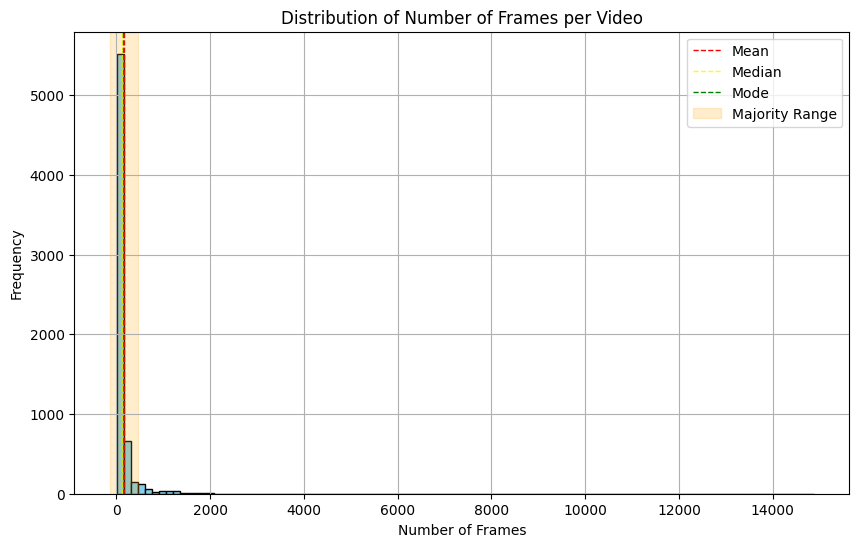

In [162]:
if PLOT_FRAME_DISTRIBUTION:
  number_of_frames = create_frame_distribution(total_normal_videos + total_violent_videos)
  plot_frame_distribution(number_of_frames)

# Process video data

In [163]:
from enum import Enum

# class syntax
class Label(Enum):
    VIOLENT = "Violent"
    NORMAL = "Normal"

In [164]:
import cv2

def duplicate_frames(frames, target_count):
    # Duplicate the last available frame to fill missing frames
    last_frame = frames[-1]
    while len(frames) < target_count:
        frames.append(last_frame.copy())
    return frames

def interpolate_frames(frames, target_count):
    if len(frames) == 0:
        Exception("No Frames Found")
    # Interpolate between the last available frame and the next available frame to generate missing frames
    # Linear interpolation
    frame_index = 1
    while len(frames) < target_count:
        prev_frame = frames[frame_index - 1]
        next_frame = frames[frame_index - 1] if frame_index + 1 == len(frames) - 1 else frames[frame_index + 1]
        interpolated_frame = cv2.addWeighted(prev_frame, 0.5, next_frame, 0.5, 0)
        frames.insert(frame_index, interpolated_frame)

        # if we reach the end, let's start from scratch
        if frame_index == len(frames) - 1:
            frame_index = 0

        frame_index += 1

    return frames

def normalize(frame):
    # Normalize the frame
    frame = frame.astype(np.float32) / 255.0

    return frame

def resize(frame, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    # Resize all frames to same dimension
    frame = cv2.resize(frame, dsize=target_size)

    return frame

def convert_grayscale(frame):
    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    return frame

In [165]:
# Function to process a single video and its annotation
import os
import cv2

def process_video(video_path, target_count):
    frames = []

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < target_count:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = normalize(frame)
            frame = resize(frame)
            frame = convert_grayscale(frame)

            frames.append(frame)

        frames = interpolate_frames(frames, target_count)
    elif total_frames > target_count:
        # Video has more frames, cut into segments of target_count
        segment_count = total_frames // target_count
        for i in range(segment_count):
            start_frame = i * target_count
            end_frame = start_frame + target_count
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            while start_frame < end_frame:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = normalize(frame)
                frame = resize(frame)
                frame = convert_grayscale(frame)

                frames.append(frame)
                start_frame += 1
    else:
        # Video has exactly the target count of frames
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = normalize(frame)
            frame = resize(frame)
            frame = convert_grayscale(frame)

            frames.append(frame)

    cap.release()
    return frames

In [166]:
def save_processed_videos(video_file_path, label, dataset_file, target_count=MAX_NUM_FRAMES):
    frames = process_video(video_file_path, target_count)
    num_of_batches = len(frames) // target_count
    video_file_name = video_file_path.split('/')[-1].split('.')[0]
    for f_idx in range(num_of_batches):
        video_name = f"{video_file_name}_{f_idx}"
        frames_dataset = create_hdf5_dataset(dataset_file, f"{video_name}/frames", (target_count, IMG_WIDTH, IMG_HEIGHT, 1))  # Create dataset for frames
        labels_dataset = create_hdf5_dataset(dataset_file, f"{video_name}/labels", (target_count,), np.integer)
        # Iterate through processed frames
        frame_count = 0

        for frame in frames[f_idx * target_count:(f_idx + 1) * target_count]:
            frame = frame.reshape(IMG_WIDTH, IMG_HEIGHT, 1)     # Reshape to add a single channel for grayscale
            frame = frame.reshape(1, IMG_WIDTH, IMG_HEIGHT, 1)  # Reshape again to add the first dimension for a single frame

            # Use indexing with dynamic dimension
            frame_label = 1 if label == Label.VIOLENT else 0
            frames_dataset[frame_count] = frame
            labels_dataset[frame_count] = frame_label
            frame_count += 1

In [167]:
import h5py


# Function to create HDF5 file (handles potential overwrite)
def create_hdf5_file(filepath):
    try:
        hdf5_file = h5py.File(filepath, "w")  # Try creating in write mode
        return hdf5_file
    except OSError:  # Handle potential overwrite error
        os.remove(filepath)  # Remove existing file
        print(f"Removed existing file: {filepath}")
        hdf5_file = h5py.File(filepath, "w")  # Retry creating
        return hdf5_file

def open_hdf5_file(filepath):
    try:
        hdf5_file = h5py.File(filepath, "a")  # Try opening in write mode
        return hdf5_file
    except OSError as e:
        print(f"Error opening existing file: {filepath}\n{e}")
        return hdf5_file

In [168]:
import progressbar


def process_videos(videos, train_file, val_file):
  """
  viceos: Tuple: (video_path: string, label: Label)
  train_file: hdf5 file for train dataset
  val_file: hdf5 file for val dataset
  """
  bar = progressbar.ProgressBar(maxval=len(videos), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()
  processed = 0
  for (video_path, label) in videos:
      if processed / len(videos) < 0.8:
          save_processed_videos(video_path, label=label, dataset_file=train_file, target_count=MAX_NUM_FRAMES)
      else:
          save_processed_videos(video_path, label=label, dataset_file=val_file, target_count=MAX_NUM_FRAMES)

      processed += 1
      bar.update(processed)
  bar.finish()
  print(f'\n Processed {processed} videos\n')


In [169]:
from typing import Tuple
import os


# Define a dictionary to store frame data and category within HDF5 datasets
def create_hdf5_dataset(hdf5_file, name, shape: Tuple = (MAX_NUM_FRAMES, IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.float32):
  dataset = hdf5_file.create_dataset(name, shape, dtype=dtype)
  return dataset

In [170]:
import random


def save_dataset(all_videos, train_hdf5_file, val_hdf5_file):
    try:
        # load less volume for testing purposes
        if IS_TEST_RUN:
            all_videos = random.sample(all_videos, 50)

        # Process normal videos
        process_videos(all_videos, train_hdf5_file, val_hdf5_file)

        total = len(all_videos)
        print(f'\nTotal videos processed: {total}, Train: {total * 0.8}, Val: {total * 0.2}')

    except Exception as e:
        print(f'ERROR: {e}')
        print('Datasets not saved properly')
        raise Exception(e)

    finally:
        # Close the HDF5 files after processing all videos
        train_hdf5_file.close()
        val_hdf5_file.close()

    print("Datasets are saved in HDF5 files correctly")
    print(f"Train dataset: {DATASET_TRAIN_PATH}")
    print(f"Val dataset: {DATASET_VAL_PATH}")

In [171]:
import random

if CREATE_DATASET:
  train_hdf5_file = create_hdf5_file(DATASET_TRAIN_PATH)
  val_hdf5_file = create_hdf5_file(DATASET_VAL_PATH)
else:
  train_hdf5_file = open_hdf5_file(DATASET_TRAIN_PATH)
  val_hdf5_file = open_hdf5_file(DATASET_VAL_PATH)


# label all normal and violent videos and shuffle them
all_videos = list()
for normal in total_normal_videos:
  all_videos.append((normal, Label.NORMAL))
for violent in total_violent_videos:
  all_videos.append((violent, Label.VIOLENT))

random.shuffle(all_videos)


save_dataset(all_videos, train_hdf5_file, val_hdf5_file)
train_hdf5_file.close()
val_hdf5_file.close()

[========================================================================] 100%



 Processed 6678 videos


Total videos processed: 6678, Train: 5342.400000000001, Val: 1335.6000000000001
Datasets are saved in HDF5 files correctly
Train dataset: Info/violence_detection_train.hdf5
Val dataset: Info/violence_detection_val.hdf5


In [172]:
# Function to explore the datasets
def traverse_datasets(hdf_file):
    """Traverse all datasets across all groups in HDF5 file."""

    import h5py

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = '{}/{}'.format(prefix, key)
            if isinstance(item, h5py.Dataset):  # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group):  # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    with h5py.File(hdf_file, 'r') as f:
        print(f'Number of keys {len(f.keys())}\n')
        for (path, dset) in h5py_dataset_iterator(f):
            print(path, dset)

    return None

---

# Model-1: Simple CNN for Violence Detection
This is a basic CNN structure suitable for initial exploration. We'll break it down step-by-step:

## Input Layer:
Takes a single frame as input, assuming a shape of (224, 224, 1) (grayscale).

## Convolutional Layer:
Applies a set of filters (kernels) to the input frame to extract features.
Typical choices for the first layer could be:

* Number of filters: 32
* Kernel size: 3x3
* Activation function: ReLU (Rectified Linear Unit)

## Pooling Layer (Optional):
Reduces the dimensionality of the data extracted by the convolutional layer.
Options include MaxPooling or AveragePooling with a kernel size of 2x2 and a stride of 2.

## Flatten Layer:
Converts the output from the convolutional layers (usually a 3D array) into a 1D vector suitable for feeding into a fully-connected layer.

## Fully-Connected Layer:
Performs classification based on the extracted features.
I will use a single neuron with a sigmoid activation for binary classification (violence vs. non-violence).

In [173]:
# Execute this if you are not able to install tensorflow properly
if INSTALL_STUFF:
    !pip install tensorflow[and-cuda]
    !pip install pydot
    !pip install graphviz

In [174]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense

def get_basic_model():
    return Sequential([
      Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 1)),  # Convolutional layer
      Flatten(),
      Dense(1, activation="sigmoid")
    ])

# Visualize model
test_model = get_basic_model()
test_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 flatten_11 (Flatten)        (None, 1577088)           0         
                                                                 
 dense_22 (Dense)            (None, 1)                 1577089   
                                                                 
Total params: 1577409 (6.02 MB)
Trainable params: 1577409 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [175]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(input_shape=(224, 224, 1)):
    """Creates and compiles a simple CNN model.

    Args:
      input_shape: Shape of the input data (default (224, 224, 1) for grayscale images).

    Returns:
      Compiled Keras model.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    return model


In [176]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Reshape, Dropout

def get_lstm_model():
    model = Sequential()

    # 1st layer group
    model.add(Conv3D(32, (3, 3, 3), strides = 1, input_shape=(MAX_NUM_FRAMES, IMG_WIDTH, IMG_HEIGHT, 1), activation='relu', padding='valid'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

    model.add(Conv3D(64, (3, 3, 3), activation='relu', strides=1))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))
    shape = model.layers[-1].output_shape
    model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

    # LSTM - Recurrent Network Layer
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(.5))

    model.add((Flatten()))

    # FC layers group
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.summary()

    return model



# Visualize model
test_model = get_lstm_model()
test_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_34 (Conv3D)          (None, 158, 126, 126, 3   896       
                             2)                                  
                                                                 
 max_pooling3d_34 (MaxPooli  (None, 79, 63, 63, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_35 (Conv3D)          (None, 77, 61, 61, 64)    55360     
                                                                 
 max_pooling3d_35 (MaxPooli  (None, 38, 30, 30, 64)    0         
 ng3D)                                                           
                                                                 
 conv3d_36 (Conv3D)          (None, 36, 28, 28, 128)   221312    
                                                     

# Train the model

## Generators

In [177]:
def check_generator_output(generator, num_batches=1):
    for i in range(num_batches):
        X, y = generator[i]
        print(f"Batch {i + 1}:")
        print(f" - X shape: {X.shape}")
        print(f" - y shape: {y.shape}")
        print(f" - X dtype: {X.dtype}")
        print(f" - y dtype: {y.dtype}")
        print(f" - Sample y values: {y[:10]}")  # Display first 10 labels
        print()

In [178]:
import matplotlib.pyplot as plt

def visualize_frames(generator, num_batches=1, num_frames=5):
    for i in range(num_batches):
        X, y = generator[i]
        for j in range(num_frames):
            plt.imshow(X[j][0, :, :, 0], cmap='gray')  # Visualize the first frame of each video in the batch
            plt.title(f"Label: {y[j]}")
            plt.show()


In [179]:
def check_class_distribution(generator):
    all_labels = []
    for i in range(len(generator)):
        _, y = generator[i]
        all_labels.extend(y)

    unique, counts = np.unique(all_labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))

    print("Class Distribution:")
    for label, count in label_distribution.items():
        print(f" - Label {label}: {count} samples")


Found 6807 videos in Info/violence_detection_train.hdf5.
Found 1708 videos in Info/violence_detection_val.hdf5.
Checking training generator output...
Batch 1:
 - X shape: (5, 160, 128, 128, 1)
 - y shape: (5,)
 - X dtype: float32
 - y dtype: int64
 - Sample y values: [1 0 0 0 1]

Checking validation generator output...
Batch 1:
 - X shape: (5, 160, 128, 128, 1)
 - y shape: (5,)
 - X dtype: float32
 - y dtype: int64
 - Sample y values: [0 0 0 0 1]

Visualizing frames from training generator...


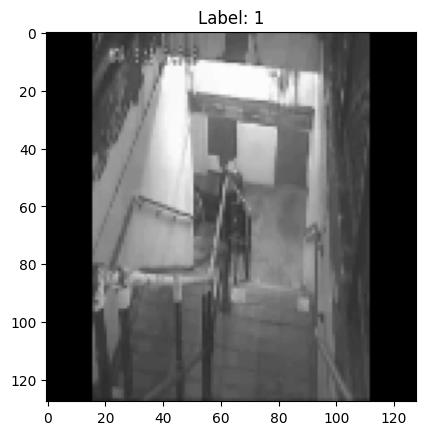

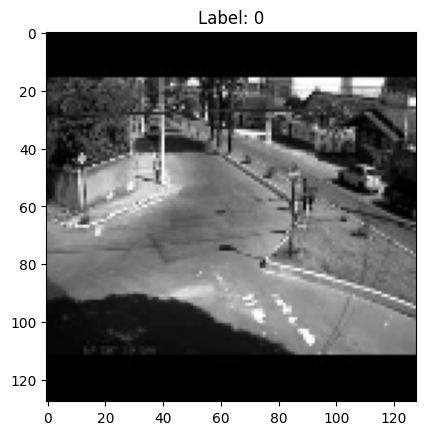

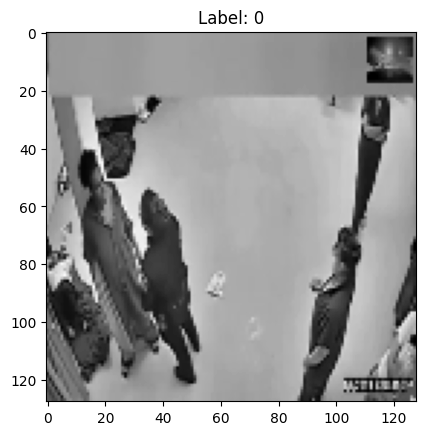

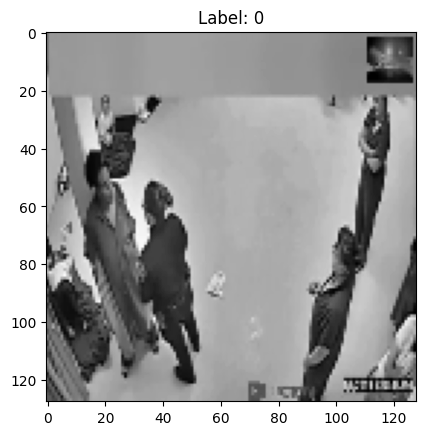

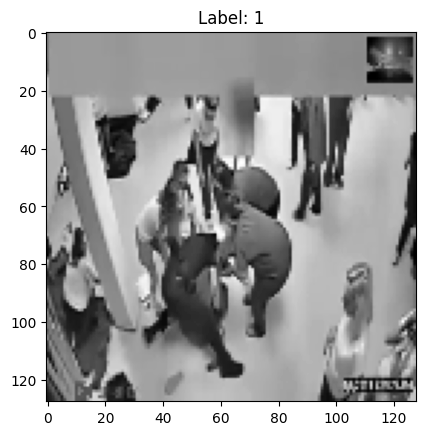

Visualizing frames from validation generator...


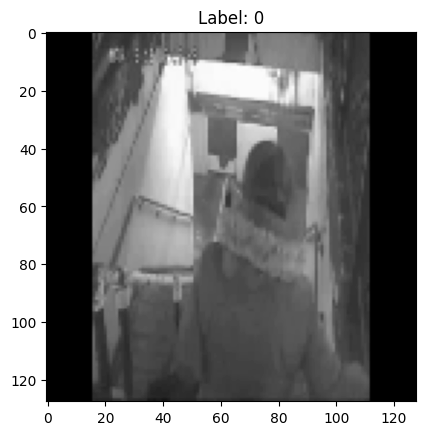

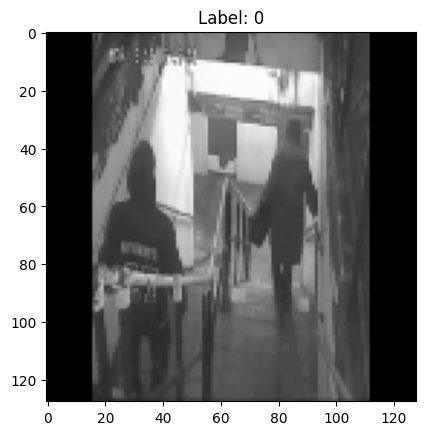

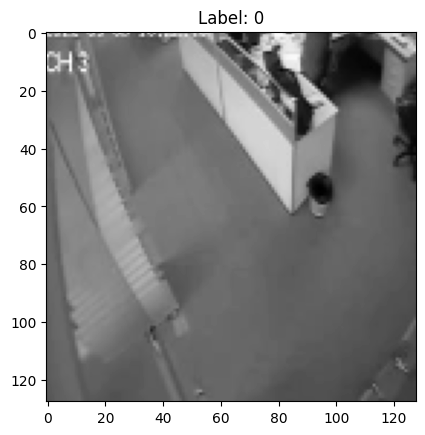

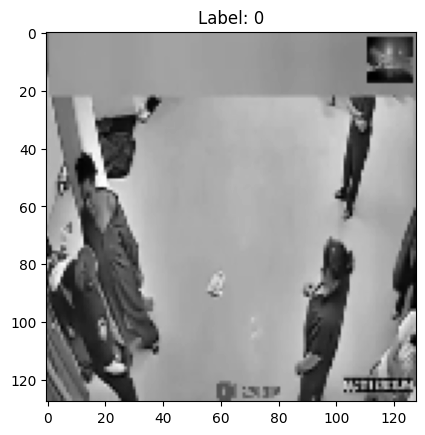

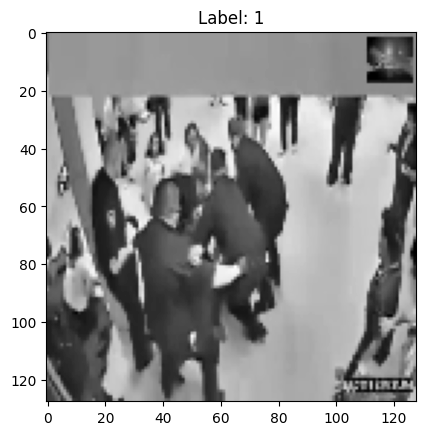

Checking class distribution in training set...
Class Distribution:
 - Label 0: 4090 samples
 - Label 1: 2717 samples
Checking class distribution in validation set...
Class Distribution:
 - Label 0: 1103 samples
 - Label 1: 605 samples


In [180]:
from tensorflow.keras.utils import Sequence
import h5py
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class HDF5DataGenerator(Sequence):
    """
    Custom data generator for HDF5 data with video fragments and labels per video.
    """

    def __init__(self, hdf5_path, batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode="binary", data_augmentation=None):
        self.hdf5_path = hdf5_path
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.data_augmentation = data_augmentation

        # Load data information from the HDF5 file
        with h5py.File(self.hdf5_path, "r") as hdf5_file:
            self.video_names = list(hdf5_file.keys())
            self.num_videos = len(self.video_names)
            print(f"Found {self.num_videos} videos in {self.hdf5_path}.")

        self.indexes = np.arange(self.num_videos)  # Create index list for shuffling

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(self.num_videos / self.batch_size))

    def __getitem__(self, index):
        # Generate a single batch of data and labels
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Load data and labels for the current batch of videos
        X, y = self._load_batch_data(indexes)

        if self.data_augmentation is not None:
          X = self.data_augmentation.apply_transformations(X)

        return X, y

    def _load_batch_data(self, indexes):
        X = []
        y = []
        with h5py.File(self.hdf5_path, "r") as hdf5_file:
            for i in indexes:
                # Access frames and labels datasets for the specific video
                frames = hdf5_file[f"{self.video_names[i]}/frames"][:]
                label = hdf5_file[f"{self.video_names[i]}/labels"][0]  # Assuming one label per video

                # Reshape frames and append to batch list
                frames = frames.reshape(-1, *self.target_size, 1)
                X.append(frames)

                # Append label to batch lists
                y.append(label)

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        # shuffle indexes for each epoch
        np.random.shuffle(self.indexes)

#############################
#### Check the generators ###
#############################

# Create data generators
train_generator = HDF5DataGenerator(DATASET_TRAIN_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
val_generator = HDF5DataGenerator(DATASET_VAL_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))

# Check generator output
print("Checking training generator output...")
check_generator_output(train_generator, num_batches=1)

print("Checking validation generator output...")
check_generator_output(val_generator, num_batches=1)

# Visualize frames
print("Visualizing frames from training generator...")
visualize_frames(train_generator, num_batches=1, num_frames=5)

print("Visualizing frames from validation generator...")
visualize_frames(val_generator, num_batches=1, num_frames=5)

# Check class distribution
print("Checking class distribution in training set...")
check_class_distribution(train_generator)

print("Checking class distribution in validation set...")
check_class_distribution(val_generator)

## Load the data

In [181]:
def load_dataset_data(dataset_name):
    X = []
    y = []
    frame_lengths = []
    with h5py.File(dataset_name, "r") as hdf5_file:
        video_names = list(hdf5_file.keys())
        for video_name in video_names:
            # Access frames and labels datasets for the specific video
            frames = hdf5_file[f"{video_name}/frames"][:]
            labels = hdf5_file[f"{video_name}/labels"][:]

            # TODO pad the frame data here to avoid homogenous issue

            # Append data and label to batch lists
            X.append(frames)
            y.append(labels)
            frame_lengths.append(frames.shape[0])

    return np.array(X), np.array(y), np.array(frame_lengths)

In [182]:
def get_dataset_size(dataset_name):
  size = 0
  with h5py.File(dataset_name, 'r') as f:
    video_names = list(f.keys())
    for v in video_names:
      size += len(f[f'{v}/frames'])

  return size

get_dataset_size(DATASET_TRAIN_PATH)

1089120

In [183]:
if INSTALL_STUFF:
    !pip install tensorboard

# launch this command in your terminal if you want to see the tensorboard
# !tensorboard --logdir=C:\Users\margo\OneDrive\UOC\projects\thesis\logs

# Open http://localhost:6006 in your browser to access tensorboard

## Training

In [184]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

def train_model_using_generators(model, epochs=EPOCHS, n_splits=5):
    """Trains a model on the provided data using data generators.

    Args:
      model: The Keras model to be trained.
      epochs: Number of training epochs.
      n_splits: Number of cross-validation splits (default 5)

    Returns:
      The trained model, train history, and val generator
    """

    data_augmentation = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
    )

    # Generators
    train_generator = HDF5DataGenerator(DATASET_TRAIN_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))
    val_generator = HDF5DataGenerator(DATASET_VAL_PATH, BATCH_SIZE, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Callbacks
    my_callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'checkpoints', 'model.{epoch:02d}-{val_loss:.2f}.h5'),
                        save_best_only=True),
        TensorBoard(log_dir=LOGS_PATH),
    ]

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    train_history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=my_callbacks
    )

    return model, train_history, val_generator


In [185]:
from keras.layers import Conv3D, Conv2D, MaxPooling2D, TimeDistributed, Flatten, LSTM, Dropout, Dense, BatchNormalization, MaxPooling3D
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os

def create_video_model(input_shape=(MAX_NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 1), num_classes=1):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),  # Pool only in spatial dimensions

        Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),  # Pool only in spatial dimensions

        Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),  # Pool only in spatial dimensions

        Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),  # Pool only in spatial dimensions

        TimeDistributed(Flatten()),  # Flatten the output of each time step
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.5),  # Dropout to prevent overfitting

        LSTM(32, kernel_regularizer=l2(0.01)),  # Another LSTM layer for added depth
        Dropout(0.5),

        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Sigmoid for binary classification
    ])

    return model

# Create the video model
video_model = create_video_model()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_41 (Conv3D)          (None, 160, 128, 128, 3   896       
                             2)                                  
                                                                 
 batch_normalization_32 (Ba  (None, 160, 128, 128, 3   128       
 tchNormalization)           2)                                  
                                                                 
 max_pooling3d_41 (MaxPooli  (None, 160, 64, 64, 32)   0         
 ng3D)                                                           
                                                                 
 conv3d_42 (Conv3D)          (None, 160, 64, 64, 64)   55360     
                                                                 
 batch_normalization_33 (Ba  (None, 160, 64, 64, 64)   256       
 tchNormalization)                                   

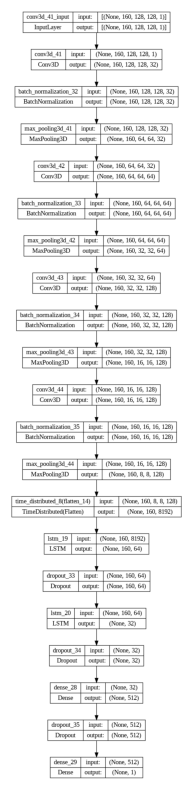

In [186]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from scipy import stats as st
import progressbar

m = create_video_model()
m.summary()

def plot_model_diagram(model, file_path='model_diagram.png'):
    plot_model(model, to_file=file_path, show_shapes=True, show_layer_names=True)
    img = plt.imread(file_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

plot_model_diagram(m)

In [187]:
from keras.models import load_model

# Train the model
model = create_video_model()
if LOAD_MODEL:
    trained_model, train_history, val_generator = load_model(MODELS_PATH, 'basic_model.keras')
else:
    trained_model, train_history, val_generator = train_model_using_generators(model, epochs=EPOCHS)

model.save(os.path.join(MODELS_PATH, 'basic_model.keras'))

Found 6807 videos in Info/violence_detection_train.hdf5.
Found 1708 videos in Info/violence_detection_val.hdf5.
Epoch 1/30
1362/1362 [==============================] - 1045s 763ms/step - loss: 1.5845 - accuracy: 0.8175 - val_loss: 2.2836 - val_accuracy: 0.3753
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1362/1362 [==============================] - 1012s 743ms/step - loss: 1.6586 - accuracy: 0.8287 - val_loss: 1.4016 - val_accuracy: 0.8571
Epoch 3/30
1362/1362 [==============================] - 1009s 741ms/step - loss: 1.6239 - accuracy: 0.8258 - val_loss: 1.5360 - val_accuracy: 0.8343
Epoch 4/30
1362/1362 [==============================] - 1032s 757ms/step - loss: 1.6711 - accuracy: 0.8306 - val_loss: 1.6950 - val_accuracy: 0.8595
Epoch 5/30
1362/1362 [==============================] - 1025s 753ms/step - loss: 1.6971 - accuracy: 0.8362 - val_loss: 1.3397 - val_accuracy: 0.8542
Epoch 6/30
1362/1362 [==============================] - 1025s 753ms/step - loss: 1.6344 - accuracy: 0.8350 - val_loss: 1.5710 - val_accuracy: 0.8536
Epoch 7/30
1362/1362 [==============================] - 1021s 750ms/step - loss: 1.4288 - accuracy: 0.8484 - val_loss: 1.2705 - val_accuracy: 0.8384
Epoch 8/30
1362/1362 [==============================] - 1023s 751ms/step - loss: 1.5251 - accuracy: 0.8472 - val_loss

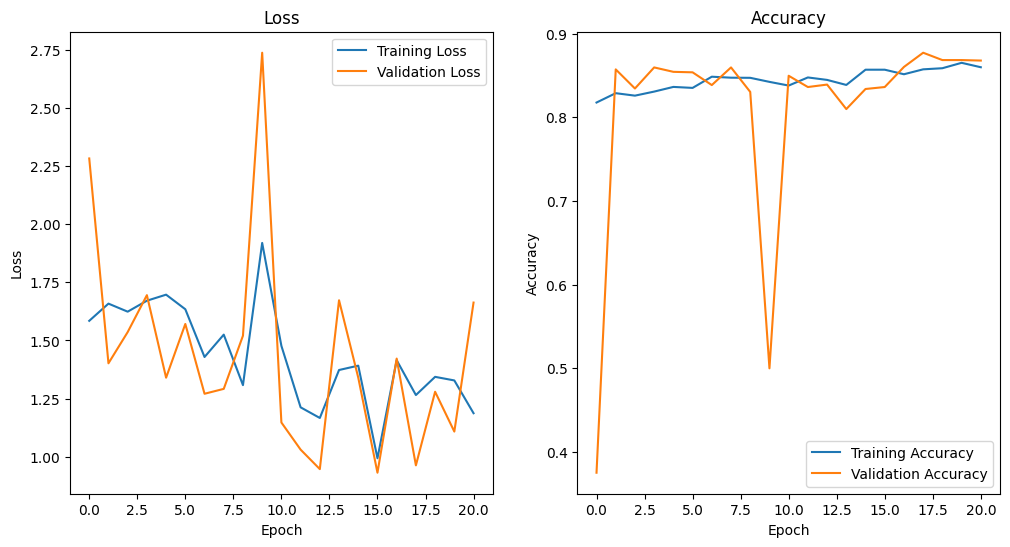

1/1 [==============================] - 0s 43ms/step
Classification Report:
y_true [0 0 0 ... 0 0 0]
y_pred [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

      Normal       0.81      0.98      0.89      1103
     Violent       0.94      0.58      0.71       605

    accuracy                           0.84      1708
   macro avg       0.87      0.78      0.80      1708
weighted avg       0.85      0.84      0.82      1708



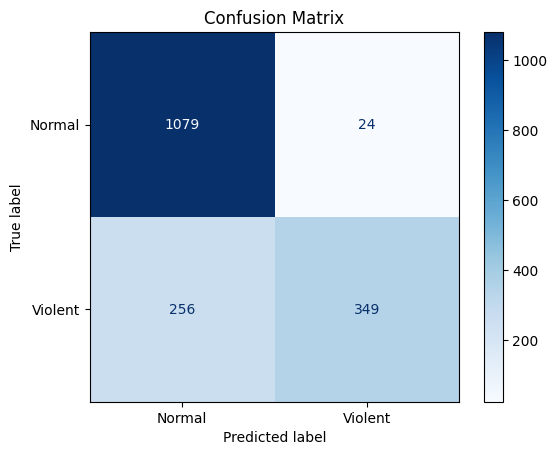

In [188]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def show_model_metrics(train_history, model, val_generator):
    # Access training and validation loss/accuracy
    train_loss = train_history.history["loss"]
    val_loss = train_history.history["val_loss"]
    train_acc = train_history.history["accuracy"]
    val_acc = train_history.history["val_accuracy"]

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Evaluate model on validation data
    y_true = []
    y_pred = []

    for batch_x, batch_y in val_generator:
        y_true.extend(batch_y)
        y_pred_batch = model.predict(batch_x)
        y_pred.extend(np.round(y_pred_batch).astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Ensure both y_true and y_pred are binary and have the same shape
    if y_true.ndim > 1:
        y_true = y_true.flatten()
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()

    # Trim y_pred to match the length of y_true if needed
    if len(y_pred) > len(y_true):
        y_pred = y_pred[:len(y_true)]
    elif len(y_true) > len(y_pred):
        y_true = y_true[:len(y_pred)]

    # Classification report
    print("Classification Report:")
    print('y_true', y_true);
    print('y_pred', y_pred);
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Violent']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violent'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


show_model_metrics(train_history, trained_model, val_generator)